# FE8819 Exotic Options and Structured Products
- Qu Mengyuan(G1900381C)
- Email: violetqu97@gmail.com
- 2020/4/11

# 1. Implied volatility

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as si
from scipy import interpolate
import datetime
from datetime import timedelta
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pylab

In [ ]:
# pip install pandas_datareader

In [5]:
import datetime
import yfinance
# from pandas_datareader import data
GE = yfinance.Ticker("GE")
today = datetime.date.today()
# St = data.DataReader("GE", "yahoo", today, today).iloc[0,-1]
St = GE.history(start='2024-01-16', end=today).iloc[-1, 3]
expire_dates = GE.options

In [7]:
OTM = pd.DataFrame()
for date in expire_dates:
    options = GE.option_chain(date)
    for i in[0,1]:
        option = options[i]
        OTM_i = option[option.inTheMoney == False]
        OTM = pd.concat([OTM,OTM_i]) 
OTM['Type'] = OTM['contractSymbol'].str[8]
OTM['Expiry Date'] = pd.to_datetime(OTM['contractSymbol'].str[2:8],format='%y%m%d')
OTM['T-t'] = ((OTM['Expiry Date']-datetime.datetime.today())/np.timedelta64(1,'D')).astype(float)/252
OTM['Implied volatility'] = 0
OTM = OTM.reset_index(drop = True)

In [18]:
n = si.norm.pdf
N = si.norm.cdf

def bs_price(cp_flag,S,K,T,r,v,q=0.0):
    d1 = (np.log(S/K)+(r+v*v/2.)*T)/(v*np.sqrt(T))
    d2 = d1-v*np.sqrt(T)
    if cp_flag == 'C':
        price = S*np.exp(-q*T)*N(d1)-K*np.exp(-r*T)*N(d2)
    else:
        price = K*np.exp(-r*T)*N(-d2)-S*np.exp(-q*T)*N(-d1)
    return price

def bs_vega(cp_flag,S,K,T,r,v,q=0.0):
    d1 = (np.log(S/K)+(r+v*v/2.)*T)/(v*np.sqrt(T))
    return S * np.sqrt(T)*n(d1)

In [19]:
def find_vol(target_value, call_put, S, K, T, r):
    MAX_ITERATIONS = 10000
    PRECISION = 1.0e-5

    sigma = 0.5
    for i in range(0, MAX_ITERATIONS):
        price = bs_price(call_put, S, K, T, r, sigma)
        vega = bs_vega(call_put, S, K, T, r, sigma)

        diff = target_value - price  # our root

        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)

    # value wasn't found, return best guess so far
    return sigma

In [20]:
for index,row in OTM.iterrows():
    OTM.iloc[index,-1] = find_vol(row[3],row[-4],St,row[2],row[-2], r=0.0127)

/tmp/ipykernel_2181437/3851835084.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  sigma = sigma + diff/vega # f(x) / f'(x)
/tmp/ipykernel_2181437/1568133304.py:5: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S/K)+(r+v*v/2.)*T)/(v*np.sqrt(T))
/tmp/ipykernel_2181437/1568133304.py:14: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S/K)+(r+v*v/2.)*T)/(v*np.sqrt(T))


In [21]:
strike = list(set(OTM.strike.tolist()))
strike.sort()
ts = OTM[['strike','T-t','Implied volatility']]
term_structure_all = pd.DataFrame()
for i in strike:
    if(i != 150):
        df = ts[ts.strike == i]
        df = df.reset_index(drop = True)
        df['sigma_t'] = np.sqrt(((df['Implied volatility']**2)*df['T-t']-(df['Implied volatility'].shift()**2)*df['T-t'].shift())
                                        /(df['T-t']-df['T-t'].shift()))
        df.loc[0,'sigma_t'] = df.loc[0,'Implied volatility']
        term_structure_all = pd.concat([term_structure_all,df]) 
term_structure_all = term_structure_all.sort_values('strike')

/home/nprivault/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nprivault/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nprivault/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nprivault/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nprivault/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nprivault/.local/lib/python3.10/site-packages/pandas/core/arraylike.p

In [22]:
tau = list(set(OTM['T-t'].tolist()))
v1 = pd.DataFrame(columns = ['strike','T-t'])
for i in strike:
    for j in tau:
        v1 = pd.concat([v1, pd.DataFrame({'strike': [i], 'T-t': [j]})]) # v1 = v1.append([{'strike':i,'T-t':j}], ignore_index=True)
v1 = pd.merge(term_structure_all, v1, how='right',on=['strike','T-t'])
v1 = v1.sort_values(['strike','T-t'])

In [23]:
implied_volatility = pd.pivot_table(v1,index=['T-t'],columns=['strike'],values=['Implied volatility'])
_, strike_iv = zip(*implied_volatility.columns.tolist())

implied_volatility.columns = list(strike_iv)
implied_volatility = implied_volatility.interpolate(method='akima', limit_direction='both', axis=1)
implied_volatility = implied_volatility.T[implied_volatility.notnull().sum() != 1].T
implied_volatility = implied_volatility.interpolate(method='akima', limit_direction='both', axis=0)
implied_volatility = implied_volatility.interpolate(method='linear', limit_direction='both', axis=1)

/tmp/ipykernel_2181437/1386125141.py:16: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


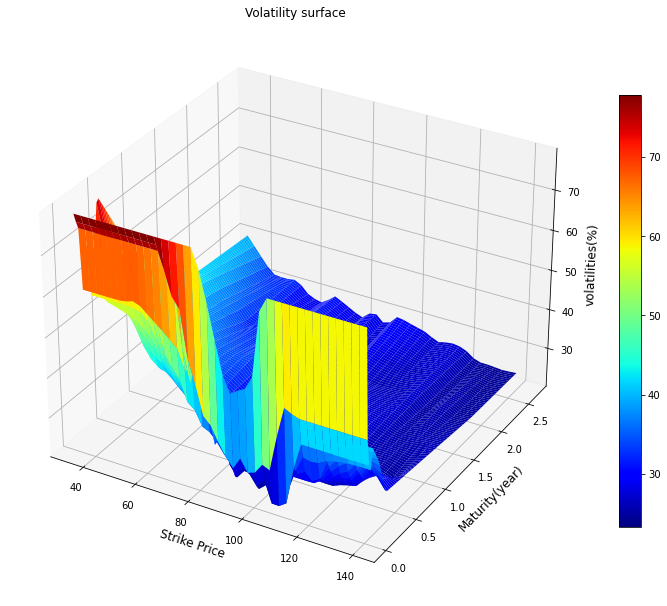

In [24]:
strike_iv = implied_volatility.columns.tolist()
tau_iv = implied_volatility.index.tolist()

x = np.array(strike_iv)
y = np.array(tau_iv)
z = np.array(implied_volatility)

f = interpolate.interp2d(x, y, z, kind='linear')
xnew = np.linspace(min(strike_iv),max(strike_iv),40)
ynew = np.linspace(min(tau_iv),max(tau_iv),90)
znew = f(xnew, ynew)

xnew, ynew = np.meshgrid(xnew, ynew)

fig = plt.figure(figsize = (10, 8))
ax = Axes3D(fig)
surface = ax.plot_surface(xnew, ynew, znew*100, rstride=1,cstride=1,cmap='jet')
ax.set_xlabel("Strike Price", fontsize=12)
ax.set_ylabel("Maturity(year)", fontsize=12)
ax.set_zlabel("volatilities(%)", fontsize=12)
ax.set_title("Volatility surface")
pylab.colorbar(surface,shrink=0.75)
plt.show()

- **Based on implied volatility from Yahoo Finance**

In [25]:
strike = list(set(OTM.strike.tolist()))
strike.sort()
ts = OTM[['strike','T-t','impliedVolatility']]
term_structure_all = pd.DataFrame()
for i in strike:
    if(i != 150):
        df = ts[ts.strike == i]
        df = df.reset_index(drop = True)
        df['sigma_t'] = np.sqrt(((df['impliedVolatility']**2)*df['T-t']-(df['impliedVolatility'].shift()**2)*df['T-t'].shift())
                                        /(df['T-t']-df['T-t'].shift()))
        df.loc[0,'sigma_t'] = df.loc[0,'impliedVolatility']
        term_structure_all = pd.concat([term_structure_all,df]) 
term_structure_all = term_structure_all.sort_values('strike')

/home/nprivault/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nprivault/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nprivault/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nprivault/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nprivault/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nprivault/.local/lib/python3.10/site-packages/pandas/core/arraylike.p

In [26]:
tau = list(set(OTM['T-t'].tolist()))
v1 = pd.DataFrame(columns = ['strike','T-t'])
for i in strike:
    for j in tau:
        v1 = pd.concat([v1, pd.DataFrame({'strike': [i], 'T-t': [j]})])
v1 = pd.merge(term_structure_all, v1, how='right',on=['strike','T-t'])
v1 = v1.sort_values(['strike','T-t'])

In [27]:
implied_volatility = pd.pivot_table(v1,index=['T-t'],columns=['strike'],values=['impliedVolatility'])
_, strike_iv = zip(*implied_volatility.columns.tolist())

implied_volatility.columns = list(strike_iv)
implied_volatility = implied_volatility.interpolate(method='akima', limit_direction='both', axis=1)
implied_volatility = implied_volatility.T[implied_volatility.notnull().sum() != 1].T
implied_volatility = implied_volatility.interpolate(method='akima', limit_direction='both', axis=0)
implied_volatility = implied_volatility.interpolate(method='linear', limit_direction='both', axis=0)
implied_volatility

,35.0,40.0,45.0,50.0,55.0,60.0,65.0,69.0,70.0,71.0,...,103.0,104.0,105.0,110.0,115.0,120.0,125.0,130.0,135.0,140.0
T-t,,,,,,,,,,,,,,,,,,,,,
0.005184,0.500005,0.250007,0.500005,0.500005,0.500005,0.500005,0.500005,0.500005,0.500005,0.500005,...,0.250007,0.250007,0.250007,0.500005,0.250007,0.250007,0.250007,0.250007,0.250007,0.125009
0.032962,0.500005,0.250007,0.509264,0.426665,0.365388,0.500005,0.500005,0.500005,0.500005,0.250007,...,0.125009,0.125009,0.250007,0.250007,0.250007,0.250007,0.250007,0.250007,0.250007,0.125009
0.056772,0.500005,0.250007,0.509831,0.396054,0.310695,0.408642,0.500005,0.264007,0.250007,0.250007,...,0.125009,0.125009,0.126511,0.170651,0.250007,0.250007,0.250007,0.250007,0.250007,0.125009
0.088518,0.500005,0.250007,0.500005,0.408209,0.328132,0.271492,0.250007,0.250007,0.250007,0.250007,...,0.125009,0.125009,0.125009,0.138135,0.175368,0.250007,0.250007,0.250007,0.250007,0.125009
0.116296,0.500005,0.250007,0.481007,0.500005,0.500005,0.250007,0.250007,0.250007,0.250007,0.238341,...,0.106609,0.119709,0.125009,0.125009,0.125009,0.250007,0.250007,0.250007,0.250007,0.125009
0.144073,0.500005,0.250007,0.453572,0.500005,0.458990,0.401048,0.330085,0.266565,0.250007,0.226341,...,0.062509,0.062509,0.125009,0.125009,0.125009,0.204891,0.227003,0.227003,0.227003,0.125009
0.227407,0.500005,0.250007,0.347400,0.380695,0.360489,0.338955,0.250032,0.212996,0.125009,0.130009,...,0.061224,0.059938,0.062509,0.125009,0.140634,0.125009,0.166912,0.166912,0.166912,0.125009
0.338518,0.500005,0.250007,0.250007,0.250007,0.250007,0.250007,0.125009,0.125009,0.125009,0.125009,...,0.049910,0.056726,0.062509,0.062509,0.125009,0.125009,0.125009,0.125009,0.125009,0.125009
0.699629,0.373803,0.250007,0.250007,0.250007,0.125009,0.125009,0.125009,0.069009,0.062509,0.062509,...,0.030960,0.030326,0.031260,0.062509,0.062509,0.062509,0.125009,0.125009,0.125009,0.135731


/tmp/ipykernel_2181437/1386125141.py:16: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


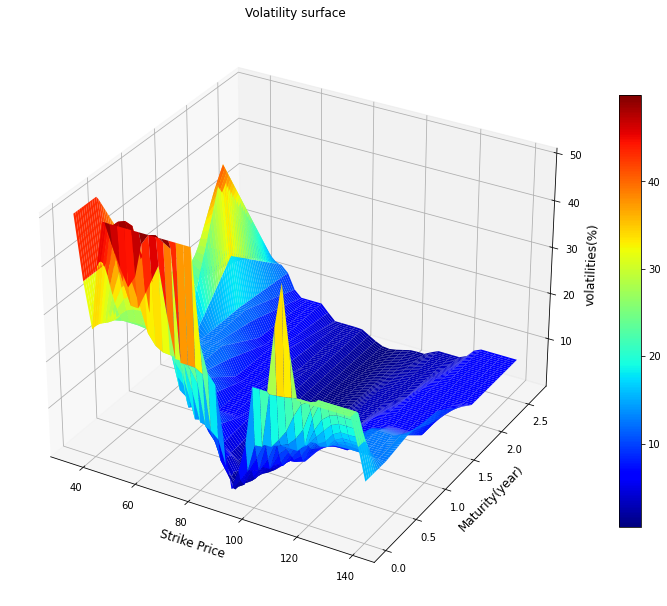

In [28]:
strike_iv = implied_volatility.columns.tolist()
tau_iv = implied_volatility.index.tolist()

x = np.array(strike_iv)
y = np.array(tau_iv)
z = np.array(implied_volatility)

f = interpolate.interp2d(x, y, z, kind='linear')
xnew = np.linspace(min(strike_iv),max(strike_iv),40)
ynew = np.linspace(min(tau_iv),max(tau_iv),90)
znew = f(xnew, ynew)

xnew, ynew = np.meshgrid(xnew, ynew)

fig = plt.figure(figsize = (10, 8))
ax = Axes3D(fig)
surface = ax.plot_surface(xnew, ynew, znew*100, rstride=1,cstride=1,cmap='jet')
ax.set_xlabel("Strike Price", fontsize=12)
ax.set_ylabel("Maturity(year)", fontsize=12)
ax.set_zlabel("volatilities(%)", fontsize=12)
ax.set_title("Volatility surface")
pylab.colorbar(surface,shrink=0.75)
plt.show()